# Lab CMBLenses

In [1]:
using Pkg
Pkg.activate(".")
Pkg.instantiate()

  Activating project at `~/Glamdring/MicroCanonicalHMC.jl/examples`


In [2]:
using Revise, Adapt, CMBLensing, CMBLensingInferenceTestProblem, CUDA, JLD2, LaTeXStrings, LinearAlgebra, 
    MCMCChains, MCMCDiagnosticTools, MicroCanonicalHMC, MuseInference, MuseInference, Plots, 
    ProgressMeter, Random, Statistics, Zygote

In [3]:
Plots.default(fmt=:png, dpi=120, size=(500,300), legendfontsize=10)

In [4]:
Nside = 64
T = Float64;

In [ ]:
prob = load_cmb_lensing_problem(;storage=Array, T, Nside, masking=true);

In [ ]:
prob.Λmass.diag.θ.r *= 5.85
prob.Λmass.diag.θ.Aϕ *= 112.09

# MCHMC

In [13]:
target = CMBLensingTarget(Cuprob);

In [14]:
d = length(prob.Ωstart)
println(d)
to_vec, from_vec = CMBLensingInferenceTestProblem.to_from_vec(Cuprob.Ωstart);

## Sample

In [31]:
precond = load("../chains/pixel_preconditioners/pp_nside_64", "dist_mat_precond");

In [32]:
precond = from_vec(adapt(CuArray, dist_mat_precond));

In [33]:
TEV = 0.0001
spl = MCHMC(500, TEV; adaptive=true, init_eps=30, init_L=10.0*sqrt(50), sigma=from_vec(dist_mat_precond),
            file_name=string("../chains/MCHMC/CMBLensing_masked_no_cosmo_TEV_", TEV));

In [34]:
prob.ncalls[] = 0
samples_mchmc = adapt(Array, Sample(spl, target, 10_000, dialog=false, progress=true));
ncalls_mchmc = prob.ncalls[]

MCHMC:   7%|███▏                                        |  ETA: 0:10:57
  ϵ:     6.107891481338328
  dE/d:  0.0001045243187351501

LoadError: InterruptException:

In [19]:
chain_mchmc = Chains(
    permutedims(reduce(hcat, [[exp.(sample[end÷2-2:end÷2-1]); sample[end-3:end]] for sample in eachcol(samples_mchmc) if all(isfinite.(sample))])),
    [:r, :Aϕ, :p_logr, :p_logAϕ, :dE, :logpdf],
);

LoadError: UndefVarError: `samples_mchmc` not defined

In [20]:
ess_mchmc = MCMCDiagnosticTools.ess(chain_mchmc)[[:r,:Aϕ],:ess]

LoadError: UndefVarError: `chain_mchmc` not defined

In [21]:
ess_per_call_mchmc = ess_mchmc / ncalls_mchmc

LoadError: UndefVarError: `ess_mchmc` not defined

## Plot

In [22]:
plot(chain_mchmc[:r], label=L"r", xlabel="step")
plot!(chain_mchmc[:Aϕ], label=L"A_\phi")

LoadError: UndefVarError: `chain_mchmc` not defined

In [23]:
plot(chain_mchmc[:p_logr], label=L"\Pi(\log \, r)", xlabel="step")
plot!(chain_mchmc[:p_logAϕ], label=L"\Pi(\log \, A_\phi)")

LoadError: UndefVarError: `chain_mchmc` not defined

In [24]:
std(chain_mchmc[:dE])^2/d

LoadError: UndefVarError: `chain_mchmc` not defined

In [25]:
d

12290

In [26]:
plot(chain_mchmc[:dE]/d, label=L"\mathrm{Energy}/d", xlabel="step")

LoadError: UndefVarError: `chain_mchmc` not defined

In [27]:
vars = var(samples_mchmc, dims=2)[1:d]
_vars = var(samples_mchmc, dims=2)[d+1:2*d]

LoadError: UndefVarError: `samples_mchmc` not defined

In [28]:
k = round(maximum(vars)/minimum(vars), digits=2)
_k = round(maximum(_vars)/minimum(_vars), digits=2)

LoadError: UndefVarError: `vars` not defined

In [29]:
plot(_vars, title="Diag(cov) - Masked", label=string("Latent space --> K = ", _k))
#plot!(vars, label=string("Parameter space --> K = ", k))

LoadError: UndefVarError: `_k` not defined

In [30]:
using CMBLensing: fit, Histogram, Weights
_vars_q = _vars[1:Int((d-2)/3)]
_vars_u = _vars[Int((d-2)/3)+1:Int(2*(d-2)/3)];

LoadError: UndefVarError: `_vars` not defined

In [31]:
_edges = range(-0.3,15,length=20)
hist_vars_q = fit(Histogram, vec(dist_mat), Weights(_vars_q), _edges).weights ./ fit(Histogram, vec(dist_mat), Weights(ones(length(_vars_q))), _edges).weights
hist_vars_u = fit(Histogram, vec(dist_mat), Weights(_vars_u), _edges).weights ./ fit(Histogram, vec(dist_mat), Weights(ones(length(_vars_q))), _edges).weights
plot(_edges, hist_vars_q, seriestype=:scatter,
     xlabel="distance to edge",
     ylabel="variance of pixel",
     label="Q-field", alpha=0.7)
plot!(_edges, hist_vars_u, seriestype=:scatter,
     xlabel="distance to edge",
     ylabel="variance of pixel",
     label="U-field", alpha=0.7)
     


LoadError: UndefVarError: `_vars_q` not defined

In [32]:
histogram2d(chain_mchmc[:r], chain_mchmc[:Aϕ], bins=(40, 20), show_empty_bins=true,
    normalize=:pdf, color=:plasma)
title!("Masked - NSIDE=64")
ylabel!("Aϕ")
xlabel!("r")

LoadError: UndefVarError: `chain_mchmc` not defined

In [33]:
plot(
    histogram(chain_mchmc[:r], xlabel=L"r", label=nothing, lw=1),
    histogram(chain_mchmc[:Aϕ], xlabel=L"A_\phi", label=nothing, lw=1),
    size = (700,300)
)

LoadError: UndefVarError: `chain_mchmc` not defined

### Animation

In [34]:
to_vec, from_vec = CMBLensingInferenceTestProblem.to_from_vec(prob.Ωstart)
last_sample = from_vec(samples_mchmc[end][1:end-2]);

LoadError: UndefVarError: `samples_mchmc` not defined

In [35]:
ps = map([(:ϕ°,:I,L"L",L"\phi^\circ"), (:f°,:E,"L\ell",L"E^\circ"), (:f°,:B,L"\ell",L"B^\circ")]) do (k1, k2, xlabel, title)
    plot(get_Cℓ(prob.Ωtrue[k1][k2]); label="true", xlabel, title)
    plot!(get_Cℓ(prob.Ωstart[k1][k2]); label="start", xlabel, title)
    plot!(get_Cℓ(last_sample[k1][k2]); label="last sample", xlabel, title)
end
plot(ps..., layout=(1,3), xscale=:log10, yscale=:log10, size=(1000,300), legend=:bottomleft)

LoadError: UndefVarError: `last_sample` not defined

In [36]:
ϕs = [∇²*from_vec(sample[1:end-2]).ϕ°/2 for sample in samples_mchmc[end-500:end]]
anim = @animate for i in 1:length(ϕs)
    motionblur = [0.5, 1, 0.5]
    frame = sum(circshift(ϕs, i)[1:length(motionblur)] .* motionblur) / sum(motionblur)
    plot(1 * frame, clims=(-0.5, 0.5), c=:thermal, title="κ samples")
end;

LoadError: UndefVarError: `samples_mchmc` not defined

In [37]:
mp4(anim, "kappa_samples.mp4", fps = 25)

LoadError: UndefVarError: `anim` not defined

# HMC

In [38]:
Ω = prob.Ωstart
samples_hmc = []
rng = Xoshiro(1)
prob.ncalls[] = 0
@showprogress for i=1:500
    Ω, = state = hmc_step(rng, prob, Ω, prob.Λmass; symp_kwargs=[(N=25, ϵ=0.05)], progress=false, always_accept=(i<10))
    push!(samples_hmc, state)
end
ncalls_hmc = prob.ncalls[]

Progress:  19%|███████▊                                 |  ETA: 0:25:58

LoadError: InterruptException:

In [39]:
_samples_hmc = zeros(500, 12290)
for i in 1:100
    _samples_hmc[i, :] = samples_hmc[i][1][:]
end

LoadError: BoundsError: attempt to access 95-element Vector{Any} at index [96]

In [40]:
@save "../chains/HMC/CMBLensing_masked." _samples_hmc

In [41]:
chain_hmc = Chains(
    permutedims(reduce(hcat, [exp.(sample[1].θ) for sample in samples_hmc])),
    [:r, :Aϕ],
);

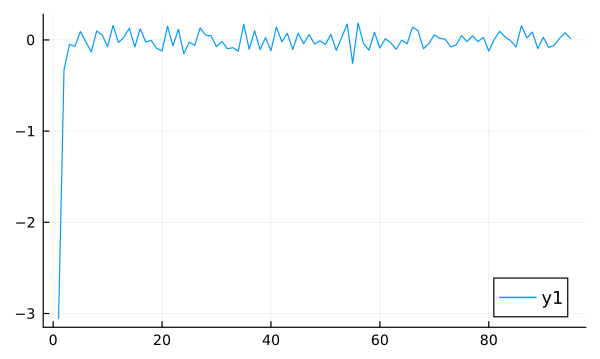

In [42]:
plot(getindex.(samples_hmc, 2))

## Plot

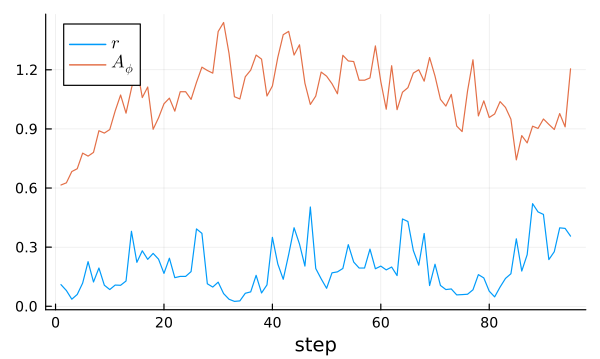

In [43]:
plot(chain_hmc[:r], label=L"r", xlabel="step")
plot!(chain_hmc[:Aϕ], label=L"A_\phi")

In [44]:
ess_hmc = MCMCDiagnosticTools.ess(chain_hmc)[[:r,:Aϕ],:ess]

2-element Vector{Float64}:
 18.03428417982361
  9.766194958409525

In [45]:
ess_per_call_hmc = ess_hmc ./ ncalls_hmc

LoadError: UndefVarError: `ncalls_hmc` not defined

# MUSE

In [7]:
using CMBLensing.ComponentArrays, MuseInference.FiniteDifferences

In [8]:
muse_prob = CMBLensingMuseProblem(
    prob.ds, 
    MAP_joint_kwargs = (minsteps=3, nsteps=15, αtol=1e-2, gradtol=3e-5, progress=false, history_keys=(:logpdf, :ΔΩ°_norm)),
);

In [9]:
# small hack to allow getting MUSE covariance in terms of transformed θ
CMBLensingMuseInferenceExt = Base.get_extension(CMBLensing,:CMBLensingMuseInferenceExt)
CMBLensingMuseInferenceExt.mergeθ(prob::CMBLensingMuseProblem, θ) = exp.(θ)

LoadError: ArgumentError: invalid type for argument prob in method definition for mergeθ at In[9]:3

In [10]:
# z₀ = zero(FieldTuple(MuseInference.select(NamedTuple(prob.Ωstart), (:f°, :ϕ°))))
# H_pre = Diagonal(FieldTuple(MuseInference.select(NamedTuple(prob.Λmass.diag), (:f°, :ϕ°))))
# H_pre_map = let H_pre=H_pre, z₀=z₀
#     MuseInference.LinearMap{eltype(z₀)}(length(z₀), issymmetric=true) do z
#         f, = promote(z, z₀)
#         LenseBasis(H_pre \ f)[:]
#     end
# end
# implicit_diff_cg_kwargs = (maxiter=1500,Pl=MuseInference.InverseMap(H_pre_map));

In [11]:
z₀ = zero(MuseInference.sample_x_z(muse_prob, Xoshiro(0), prob.Ωstart.θ).z);
result = MuseResult()
nsims = 200
rng = Xoshiro(0)

prob.ncalls[] = 0
MuseInference.muse!(result,  muse_prob, prob.Ωstart.θ; nsims, rng, z₀, maxsteps=2, θ_rtol=0, progress=true, save_MAPs=false)
MuseInference.get_J!(result, muse_prob; nsims,   rng, z₀, progress=true)
MuseInference.get_H!(result, muse_prob; nsims=4, rng, z₀, progress=true, step=std(result.gs)/100, fdm=central_fdm(2,1,adapt=0))
ncalls_muse = prob.ncalls[];

LoadError: AssertionError: !(isnan(res))

In [12]:
chain_muse = Chains(permutedims(rand(result.dist,1000000)), [:logr, :logAϕ]);

LoadError: MethodError: no method matching Random.Sampler(::Type{TaskLocalRNG}, ::Random.SamplerTrivial{Nothing, Any}, ::Val{1})

[0mClosest candidates are:
[0m  Random.Sampler(::Type{<:AbstractRNG}, ::Random.Sampler, ::Union{Val{1}, Val{Inf}})
[0m[90m   @[39m [33mRandom[39m [90m~/.julia/juliaup/julia-1.9.0-rc2+0.x64.linux.gnu/share/julia/stdlib/v1.9/Random/src/[39m[90m[4mRandom.jl:148[24m[39m
[0m  Random.Sampler(::Type{<:AbstractRNG}, ::Any, ::Union{Val{1}, Val{Inf}})
[0m[90m   @[39m [33mRandom[39m [90m~/.julia/juliaup/julia-1.9.0-rc2+0.x64.linux.gnu/share/julia/stdlib/v1.9/Random/src/[39m[90m[4mRandom.jl:184[24m[39m
[0m  Random.Sampler([91m::AbstractRNG[39m, ::Any, ::Union{Val{1}, Val{Inf}})
[0m[90m   @[39m [33mRandom[39m [90m~/.julia/juliaup/julia-1.9.0-rc2+0.x64.linux.gnu/share/julia/stdlib/v1.9/Random/src/[39m[90m[4mRandom.jl:140[24m[39m
[0m  ...


In [13]:
ess_per_call_muse = nsims / ncalls_muse

LoadError: UndefVarError: `ncalls_muse` not defined

## Plot

In [22]:
plot(
    map(result.history[1:1:end]) do h
        p = plot()
        for x in h.ẑ_history_sims
            plot!(first.(x), yscale=:log10)
        end
        plot!(first.(h.ẑ_history_dat), yscale=:log10, c=:black)
        p
    end...,
    size = (1000,500),
    xticks = 0:2:15,
    # ylim = (1e-7, 1e-3)
)

LoadError: UndefVarError: `result` not defined

In [23]:
plot(
    map(result.history[1:1:end]) do h
        p = plot()
        for x in h.ẑ_history_sims
            plot!(last.(x), yscale=:log10)
        end
        plot!(last.(h.ẑ_history_dat), yscale=:log10, c=:black)
        p
    end...,
    size = (1000,500),
    xticks = 0:2:15,
    ylim = (1e-7, 1e-3)
)

LoadError: UndefVarError: `result` not defined

In [24]:
plot(
    plot(getindex.([getindex.(result.history, :θ); [result.θ]], :r), m="."),
    plot(getindex.([getindex.(result.history, :θ); [result.θ]], :Aϕ), m=".")
)

LoadError: UndefVarError: `result` not defined

# Compare

In [56]:
ess_per_call_muse ./ minimum(ess_per_call_hmc)

LoadError: UndefVarError: `ess_per_call_muse` not defined

In [57]:
ess_per_call_muse ./ minimum(ess_per_call_mchmc)

LoadError: UndefVarError: `ess_per_call_muse` not defined

In [58]:
ess_per_call_mchmc

LoadError: UndefVarError: `ess_per_call_mchmc` not defined

In [59]:
ess_per_call_hmc

LoadError: UndefVarError: `ess_per_call_hmc` not defined

In [60]:
ess_per_call_muse

LoadError: UndefVarError: `ess_per_call_muse` not defined

In [61]:
which_ess = minimum # can be: first (r), last (Aphi), or minimum
bar(
    ["HMC" "MCHMC" "MUSE"],
    which_ess.([[ess_per_call_hmc] [ess_per_call_mchmc] [ess_per_call_muse]]),
    ylabel = "eff. samples / ∇logP eval", legend=false)

LoadError: UndefVarError: `ess_per_call_hmc` not defined

In [62]:
p = plot(label=L"r", xlabel="step (scaled consistently for both)")
for k in [:r, :Aϕ]
    plot!(log.(chain_hmc[k][1:length(chain_mchmc)÷25]), c=1, label=(k==:r ? "HMC" : nothing))
    plot!(log.(chain_mchmc[k][1:25:end]), c=2, label=(k==:r ? "MCHMC" : nothing))
end
p

LoadError: UndefVarError: `chain_mchmc` not defined

In [63]:
plot(
    begin
        histogram(log.(chain_hmc[:r]), normalize=:pdf, alpha=0.5, bins=range(-4,0,length=40), label="HMC")
        histogram!(log.(chain_mchmc[:r]), normalize=:pdf, alpha=0.5, bins=range(-4,0,length=40), label="MCHMC")
        histogram!(chain_muse[:logr], normalize=:pdf, alpha=0.5, bins=range(-4,0,length=40), label="MUSE")
        vline!([prob.Ωtrue.θ.r], c=4, lw=3, label="Truth")
    end, 
    begin
        histogram(log.(chain_hmc[:Aϕ]), normalize=:pdf, alpha=0.5, bins=range(-0.6,0.6,length=40), label="HMC")
        histogram!(log.(chain_mchmc[:Aϕ]), normalize=:pdf, alpha=0.5, bins=range(-0.6,0.6,length=40), label="MCHMC")
        histogram!(chain_muse[:logAϕ], normalize=:pdf, alpha=0.5, bins=range(-0.6,0.6,length=40), label="MUSE")
        vline!([prob.Ωtrue.θ.Aϕ], c=4, lw=3, label="Truth")
    end, 
    size = (700, 300)
)

LoadError: UndefVarError: `chain_mchmc` not defined